In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import os
from scipy.interpolate.rbf import Rbf
from scipy import stats
import copy 
import uuid
from functools import partial
from skopt import space, gp_minimize

import warnings
warnings.simplefilter('ignore')
from tqdm.notebook import trange

In [4]:
def idea_for_weights(func = 'inverse'):
  x, y = list(zip(*[[0,0],[9,9]]))
  z = [1]*len(x)

  rbf_adj = Rbf(x, y, z, function=func, epsilon = 0.01 * 10 * 10)

  x_fine, y_fine = list(zip(*[[i,j] for i in range(10) for j in range(10)]))

  x_grid, y_grid = np.meshgrid(x_fine, y_fine)

  z_grid = 1 - rbf_adj(x_grid.ravel(), y_grid.ravel()).reshape(x_grid.shape)

  plt.pcolor(x_fine, y_fine, z_grid);
  plt.plot(x, y, 'ok');
  plt.xlabel('x'); plt.ylabel('y'); plt.colorbar();
  plt.title(f'RBF {func} interpolation');

In [5]:
import numpy as np
import random


class cell:
    def __init__(self, **kwargs):
        self.number = kwargs.get("number")
        self.adj = kwargs.get("adj")
        self.is_bomb = kwargs.get("is_bomb")
        self.pos= kwargs.get("pos")
        self.is_checked= False
        self.is_flaged =False
        
#Create the Board
def createBoard(num_row ,num_col):
    '''Number of bomb that is needed to be placed randomly'''
    number_bomb = int(0.15*(num_col*num_row))

    '''Create all the postion in a Cell *object*  with no adj and no bomb for now'''
    cell_list =[]
    for i in range(num_row):
        for j in range(num_col):
            cell_list.append(cell(number = 0 ,adj =None , is_bomb =None))
 
    '''Reshape it into num_row and num_col'''
    board =np.array(cell_list).reshape(num_row, num_col)
    
    '''Check bomb is for the number of bomb placed'''
    check_bombs=0

    def Cell(choice):
        return board[choice[0]][choice[1]]

    '''This is for filling the attributes of each Cell *object* '''
    for i in range(num_row):
        for j in range(num_col): 
            board[i][j].pos= (i,j)
            board[i][j].is_bomb = False
            board[i][j].adj ={
                "top_left": [i-1 ,j-1] if i>0 and j>0 else None,
                "top" : [i-1,j] if i>0 else None,
                "top_right": [i-1,j+1] if i>0 and j<num_col-1 else None,
                "left": [i,j-1] if j>0 else None,
                "right": [i,j+1] if j<num_col-1 else None,
                "bottom_left": [i+1,j-1] if i<num_row-1 and j>0 else None,
                "bottom": [i+1,j] if i<num_row-1 else None,
                "bottom_right": [i+1,j+1] if i<num_row-1 and j<num_col-1 else None
            }

    '''Now to fill randomly bombs equal to number_bomb'''        
    while check_bombs != number_bomb:

        '''Random choice'''
        x=random.randrange(0,num_row-1)
        y=random.randrange(0,num_col-1)

        '''For those random choice postion change the attribute of the 
        Cell (accessed by board[x][y]) *object* and increasing check bomb by 1'''
        #Only place the bomb on that postion
        #If there is no bomb on that place already 
        if board[x][y].is_bomb is False:
            board[x][y].number = -1
            board[x][y].is_bomb = True
            check_bombs+=1
            
            for i,j in board[x][y].adj.items():
                
                acceptable = True if j != None else False
                if acceptable:
                    j = Cell(j)
                
                '''If acceptable and there is no bomb in its adjecent'''
                if acceptable and Cell(board[x][y].adj[i]).is_bomb == False:

                    '''Increment the Cell's number by 1'''
                    Cell(board[x][y].adj[i]).number+=1   
    return board


In [6]:
def update_board(choice ,action, num_row,num_col, board ,given_board, number_bomb, cell_left):
    def Given_board(choice):
        if Cell(choice).is_flaged == False:
            given_board[choice[0]][choice[1]] = Number(choice)
        if Cell(choice).is_flaged == True:
            given_board[choice[0]][choice[1]] = '#'


    def Number (choice):
        return board[choice[0]][choice[1]].number

    def Is_checked (choice, put =None):
        
        if put != None:
            board[choice[0]][choice[1]].is_checked = put
        
        else:
            return board[choice[0]][choice[1]].is_checked

    def Adj(choice):
        return board[choice[0]][choice[1]].adj

    def Cell(choice):
        return board[choice[0]][choice[1]]
    
    def Press_land(cell, open_cell):
        if cell == None or cell.number != 0:
            return
        adj=list(cell.adj.values())
        
        for this_adj in adj:
            if this_adj != None:
                this_adj = Cell(this_adj)
            if this_adj != None and cell.number == 0 and this_adj.is_checked == False:
                this_adj.is_checked = True
                open_cell.append(cell.pos)
                Given_board(this_adj.pos)
                Press_land(this_adj, open_cell)
        cell.is_checked = True
        Given_board(cell.pos)
        return open_cell
    def Hide(choice):
        given_board[choice[0], choice[1]] = '.'

    if action == 1 and Cell(choice).is_flaged:
        action = -1

    if cell_left != 0:
        if action == -1:
            Cell(choice).is_flaged = False
            Is_checked(choice ,False)
            Hide(choice)
            cell_left+=1

        
        elif action == 1:
            Cell(choice).is_flaged = True
            Is_checked(choice ,True)
            Given_board(choice)
            cell_left-=1
        else:
            if Cell(choice).is_flaged != True:
                if Number(choice) == -1:
                    #changed for convinience
                    return board,given_board, -1
                else:
                    if Number(choice) != 0:
                        Is_checked(choice , True)
                        Given_board(choice)
                        cell_left-=1
                    else:
                        open_cell = []
                        cell_left -= len(Press_land(Cell(choice), open_cell))

        if cell_left == 0:
            return board,given_board, 1
        else:
            return board,given_board, 0
    
    else:
        return board,given_board, 1


In [7]:
def Number(board, choice):
    return board[choice[0]][choice[1]].number

def Is_checked(board, choice, put =None):
    
    if put != None:
        board[choice[0]][choice[1]].is_checked = put
    
    else:
        return board[choice[0]][choice[1]].is_checked

def Adj(board, choice):
    return board[choice[0]][choice[1]].adj

def Cell(board, choice):
    return board[choice[0]][choice[1]]

def prob_of_bomb_in_area(board, prob_board, cell):
    bomb_left_to_mark = cell.number
    number_of_places_bomb_can_be = 0
    for each_adj in cell.adj.values():
        if each_adj and Cell(board, each_adj).is_flaged:
            bomb_left_to_mark -= 1
        if each_adj and not Cell(board, each_adj).is_checked:
            number_of_places_bomb_can_be += 1
    if bomb_left_to_mark != 0:
        prob = combination(number_of_places_bomb_can_be -1 , bomb_left_to_mark -1) / \
            combination(number_of_places_bomb_can_be, bomb_left_to_mark)
    else:
        prob = 0.00001
           
    for each_adj in cell.adj.values():
        if each_adj and not Cell(board, each_adj).is_checked:
            position = Cell(board, each_adj).pos
            if prob != 0.00001 and prob_board[position[0]][position[1]] != 0.00001:
                max_prob = max(prob_board[position[0]][position[1]],
                                                          prob)
                prob_board[position[0]][position[1]] = max_prob                                          
            if prob == 0.00001:
                prob_board[position[0]][position[1]] = 0.00001


def combination(n, r):
    n_fact = 1
    r_fact = 1
    n_r_fact = 1
    n_r = n - r
    for i in range(1, n+1):
        n_fact *= i
    for i in range(1, r+1):
        r_fact *= i
    for i in range(1, n_r+1):
        n_r_fact *= i
    return n_fact/ (r_fact * n_r_fact)

In [8]:
def old_solver(board, num_row, num_col, alpha = 0.1):
    given_board = np.array(["*" for i in range(num_row) for j in range(num_col)
                    ]).reshape(num_row, num_col)
    number_bomb = number_bomb = int(0.15*(num_col*num_row))
    cell_left  = num_col * num_row
    prob_board = np.array([0.0 for i in range(num_row) for j in range(num_col)
                    ]).reshape(num_row, num_col)

    status = 0
    df = pd.DataFrame()
    while not status:
        action_type = "random"
        choice_list = [[i,j] for i in range(num_row) for j in range(num_col) if not board[i][j].is_checked]
        cell_left = len(choice_list)
        action = 0
        for i in range(num_row):
            for j in range(num_col):
                if board[i][j].is_checked and not board[i][j].is_flaged:
                    total_number_of_adj_checked=0
                    total_number_of_adj_none=0
                    for each_adj in board[i][j].adj.values():
                        try:
                            total_number_of_adj_checked += int(Cell(board, each_adj).is_checked)
                        except:
                            total_number_of_adj_none += 1
                    if (8 - total_number_of_adj_none - total_number_of_adj_checked) > 0:
                        prob_of_bomb_in_area(board, prob_board, board[i][j])

        max_prob_of_bomb = [0, [-1,-1]]
        min_prob_of_bomb = [1, [-1,-1]]
        for i in range(num_row):
            for j in range(num_col):
                if [i,j] in choice_list:
                    if prob_board[i][j] > max_prob_of_bomb[0]:
                        max_prob_of_bomb[0] = prob_board[i][j]
                        max_prob_of_bomb[1] = [i,j]

                    total_number_of_adj_checked=0
                    total_number_of_adj_flag=0
                    for each_adj in Cell(board, [i,j]).adj.values():
                        try:
                            total_number_of_adj_checked += int(Cell(board, each_adj).is_checked)
                            total_number_of_adj_flag += int(Cell(board, each_adj).is_flaged)
                        except:
                            continue

                    if total_number_of_adj_checked - total_number_of_adj_flag > 0:
                        if prob_board[i][j] < min_prob_of_bomb[0]:
                            min_prob_of_bomb[0] = prob_board[i][j]
                            min_prob_of_bomb[1] = [i,j]

        if max_prob_of_bomb[0] > 1 - alpha or min_prob_of_bomb[0] < alpha:
            action_type = "probability"
            if max_prob_of_bomb[0] > 1 - alpha:
                x,y = max_prob_of_bomb[1]
                action = 1
            if min_prob_of_bomb[0] < alpha:
                x,y = min_prob_of_bomb[1]
                action = 0
        else:
            action_type = "random"
            left_cell_prob = [[prob_board[x][y],[x,y]] for x,y in choice_list]
            pick_in_this = [prob_cell[1] for prob_cell in left_cell_prob if prob_cell[0] == min(left_cell_prob)[0]]
            x,y = random.choice(pick_in_this)
        try:
            if len(choice_list):
                choice_list.remove([x,y])
        except:
            pass
        
        board, given_board, status = update_board((x,y), action, num_row,num_col, board,given_board,number_bomb,cell_left)
        prob_board = np.array([0.0 for i in range(num_row) for j in range(num_col)
                        ]).reshape(num_row, num_col)
        #if status == 0:
        #    print("\n\n", given_board)
        #elif status == 1:
        #    print("\n\n", given_board)        
        #else:
        #    print("\n\n", given_board)     

        data = {
            "action_type": [action_type],
            "action" : [action]
        }
        df = pd.concat([df, pd.DataFrame(data)])   

    return df, {"id": [uuid.uuid1()],"action_type": [action_type],"status": [status], "clicks": [num_row*num_col-len(choice_list)], 'rbf_kernal':['old']}

#def main(num_row, 
#         num_col,
#         threshold):
#    board = createBoard(num_row, num_col)
#    df, status = solver(board, num_row, num_col, threshold)
#    df.action = df.action.replace({0: "left", 1: "right"})
#    ct = pd.crosstab(df.action_type, df.action)
#    print(ct,"\n", status)
#    stacked = ct.stack().reset_index().rename(columns={0:'value'})
#    sns.barplot(x=stacked.action_type, y=stacked.value, hue=stacked.action)
#    plt.title("Lost" if status["status"] == -1 else "Win")
#    plt.show()

In [9]:
def new_solver(board, num_row, num_col, alpha = 0.1, rbf_kernal = "inverse", epsilon = 0.03):
    given_board = np.array(["*" for i in range(num_row) for j in range(num_col)
                    ]).reshape(num_row, num_col)
    number_bomb = number_bomb = int(0.15*(num_col*num_row))
    cell_left  = num_col * num_row
    prob_board = np.array([0.0 for i in range(num_row) for j in range(num_col)
                    ]).reshape(num_row, num_col)

    status = 0
    df = pd.DataFrame()
    
    def safe(x,y):
        return x == 0 or y == 0 or x == num_row-1 or y == num_col-1
    
    while not status:
        action_type = "random"
        choice_list = [[i,j] for i in range(num_row) for j in range(num_col) if not board[i][j].is_checked]
        opened_list = [[i,j] for i in range(num_row) for j in range(num_col) if board[i][j].is_checked]
        cell_left = len(choice_list)
        action = 0
        for i in range(num_row):
            for j in range(num_col):
                if board[i][j].is_checked and not board[i][j].is_flaged:
                    total_number_of_adj_checked=0
                    total_number_of_adj_none=0
                    for each_adj in board[i][j].adj.values():
                        try:
                            total_number_of_adj_checked += int(Cell(board, each_adj).is_checked)
                        except:
                            total_number_of_adj_none += 1
                    if (8 - total_number_of_adj_none - total_number_of_adj_checked) > 0:
                        prob_of_bomb_in_area(board, prob_board, board[i][j])

        max_prob_of_bomb = [0, [-1,-1]]
        min_prob_of_bomb = [1, [-1,-1]]
        for i in range(num_row):
            for j in range(num_col):
                if [i,j] in choice_list:
                    if prob_board[i][j] > max_prob_of_bomb[0]:
                        max_prob_of_bomb[0] = prob_board[i][j]
                        max_prob_of_bomb[1] = [i,j]

                    total_number_of_adj_checked=0
                    total_number_of_adj_flag=0
                    for each_adj in Cell(board, [i,j]).adj.values():
                        try:
                            total_number_of_adj_checked += int(Cell(board, each_adj).is_checked)
                            total_number_of_adj_flag += int(Cell(board, each_adj).is_flaged)
                        except:
                            continue

                    if total_number_of_adj_checked - total_number_of_adj_flag > 0:
                        if prob_board[i][j] < min_prob_of_bomb[0]:
                            min_prob_of_bomb[0] = prob_board[i][j]
                            min_prob_of_bomb[1] = [i,j]

        if max_prob_of_bomb[0] > 1 - alpha or min_prob_of_bomb[0] < alpha:
            action_type = "probability"
            if max_prob_of_bomb[0] > 1 - alpha:
                x,y = max_prob_of_bomb[1]
                action = 1
            if min_prob_of_bomb[0] < alpha:
                x,y = min_prob_of_bomb[1]
                action = 0
        else:
            action_type = "random"
            if opened_list:
                x ,y = list(zip(*opened_list))
                z = [1]*len(x)
                rbf_adj = Rbf(x, y, z, function= rbf_kernal, epsilon = epsilon * num_row * num_col)
                x_fine, y_fine = list(zip(*[[i,j] for i in range(num_row) for j in range(num_col)]))
                x_grid, y_grid = np.meshgrid(x_fine, y_fine)
                if not rbf_kernal in ["multiquadric", "linear"]:
                  weight = 1 - rbf_adj(x_grid.ravel(), y_grid.ravel()).reshape(x_grid.shape)
                else:
                  weight = rbf_adj(x_grid.ravel(), y_grid.ravel()).reshape(x_grid.shape)
            
                left_cell_prob = [[prob_board[x][y],[x,y]] for x,y in choice_list]
                pick_in_this = [prob_cell[1] for prob_cell in left_cell_prob if prob_cell[0] == min(left_cell_prob)[0]]
                left_weights = [weight[x][y] for x,y in pick_in_this]
                #random.shuffle(pick_in_this)
                x,y =pick_in_this[len(left_weights)-1-left_weights[::-1].index(max(left_weights))]
                #x,y = random.choices(pick_in_this, weights = left_weights)[0]
                
            else:
                left_cell_prob = [[prob_board[x][y],[x,y]] for x,y in choice_list if safe(x,y)]
                pick_in_this = [prob_cell[1] for prob_cell in left_cell_prob if prob_cell[0] == min(left_cell_prob)[0]]
                random.shuffle(pick_in_this)
                x,y = random.choices(pick_in_this)[0]
        try:
            if len(choice_list):
                choice_list.remove([x,y])
        except:
            pass
        
        board, given_board, status = update_board((x,y), action, num_row,num_col, board,given_board,number_bomb,cell_left)
        prob_board = np.array([0.0 for i in range(num_row) for j in range(num_col)
                        ]).reshape(num_row, num_col)
        #if status == 0:
        #    print("\n\n", given_board)
        #elif status == 1:
        #    print("\n\n", given_board)        
        #else:
        #    print("\n\n", given_board)     

        data = {
            "action_type": [action_type],
            "action" : [action]
        }
        df = pd.concat([df, pd.DataFrame(data)])   

    return df, {"id": [uuid.uuid1()],"action_type": [action_type],"status": [status], "clicks": [num_row*num_col-len(choice_list)], 'rbf_kernal':[rbf_kernal]}


multiquadric, linear

In [10]:
def generate_sample(num_row, num_col, sample_size = 100):
  num_row, num_col, threshold = (num_row,num_col,0.1)
  res_status_o = pd.DataFrame()
  kernal_status = pd.DataFrame()
  for kernal in ["multiquadric", "inverse", "gaussian"]:
    exec(f"{kernal}_res_status = pd.DataFrame()")
    #exec(f"print({kernal}_res_status)")
  for i in trange(sample_size):
    try:
      _kernal_status = pd.DataFrame()
      board_o = createBoard(num_row, num_col)
      for kernal in ["multiquadric", "inverse", "gaussian"]:
        exec(f"board_{kernal} = copy.deepcopy(board_o)")
      df_o, status_o = old_solver(board_o, num_row, num_col, threshold)
      res_status_o = pd.concat([res_status_o, pd.DataFrame(status_o)])
      for kernal in ["multiquadric", "inverse", "gaussian"]:
        exec(f"{kernal}_dfn, {kernal}_status = new_solver(board_{kernal}, num_row, num_col, threshold, rbf_kernal=kernal)")
        exec(f"{kernal}_res_status = pd.concat([{kernal}_res_status, pd.DataFrame({kernal}_status)])")

      for kernal in ["multiquadric", "inverse", "gaussian"]:
        _kernal_status = eval(f"pd.concat([_kernal_status, {kernal}_res_status])")
      
      kernal_status = pd.concat([kernal_status, _kernal_status])
      res_status = pd.concat([res_status_o, kernal_status])
    except Exception as e:
      pass
  return res_status

In [11]:
def relative_win_rate(res_status, kernal):
  return str(((res_status[(res_status.status == 1) & (res_status.rbf_kernal == kernal) ].shape[0]/res_status[(res_status.rbf_kernal == kernal) ].shape[0]) / (res_status[(res_status.status == 1) & (res_status.rbf_kernal == "old") ].shape[0]/res_status[(res_status.rbf_kernal == "old") ].shape[0])) *100) + " %"

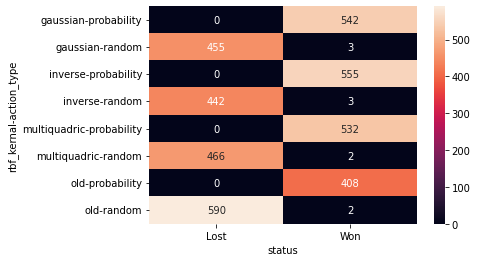

In [ ]:
#res_status = generate_sample(10,10)
#res_status.status = np.where(res_status.status == 1, "Won", "Lost")
#res_status = res_status[~res_status.id.duplicated()]
_ = res_status.pivot_table(index=['rbf_kernal','action_type'], columns= ['status'], values='id', aggfunc= 'count' , fill_value = 0)
sns.heatmap(_, annot= True, fmt = ".3g")
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

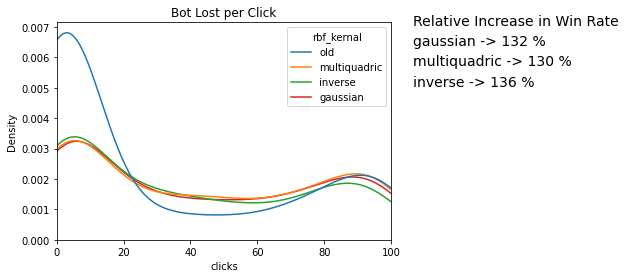

In [ ]:
res_status = generate_sample(10,10,1000)
res_status = res_status[~res_status.id.duplicated()]
res_status.reset_index(drop= True, inplace = True)
_ = res_status[res_status.status == -1]
sns.kdeplot(data = _, x = "clicks", hue = "rbf_kernal")
plt.gcf().text(0.95, 0.87, "Relative Increase in Win Rate" , fontsize=14)
plt.gcf().text(0.95, 0.8, "gaussian -> " + relative_win_rate(res_status, "gaussian") , fontsize=14)
plt.gcf().text(0.95, 0.73,"multiquadric -> " +relative_win_rate(res_status, "multiquadric"), fontsize=14)
plt.gcf().text(0.95, 0.66,"inverse -> " +relative_win_rate(res_status, "inverse"), fontsize=14)
plt.title("Bot Lost per Click")
plt.xlim(0,100)
plt.show()

In [ ]:
threshold = 0.1
win_rate_o = []
win_rate_n = []
for num_row, num_col in zip(list(range(5,20)), list(range(5,20))):
  res_status_o = pd.DataFrame()
  res_status_n = pd.DataFrame()
  for i in trange(1000):
    try:
        board_o = createBoard(num_row, num_col)
        board_n = copy.deepcopy(board_o)
        df_o, status_o = old_solver(board_o, num_row, num_col, threshold)
        dfn, status_n = new_solver(board_n, num_row, num_col, threshold, rbf_kernal="inverse")
        res_status_o = pd.concat([res_status_o, pd.DataFrame(status_o)])
        res_status_n = pd.concat([res_status_n, pd.DataFrame(status_n)])
    except:
        continue
  win_rate_o += [res_status_o[res_status_o.status == 1].shape[0] / res_status_o.shape[0]]
  win_rate_n += [res_status_n[res_status_n.status == 1].shape[0] / res_status_n.shape[0]]

In [50]:
x_axis = [str(i)+"x"+str(i) for i in range(5, 5 + len(win_rate_o))]

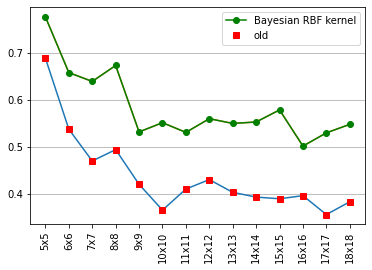

In [59]:
plt.plot(win_rate_o)
plt.plot(win_rate_n)
plt.plot(win_rate_n,'go-', label ="Bayesian RBF kernel")
plt.plot(win_rate_o,'rs',  label ="old")
plt.legend()
plt.ylim()
plt.xticks([i for i in range(14)] ,x_axis, rotation ='vertical')
plt.grid(axis = 'y')
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

(0.0, 100.0)

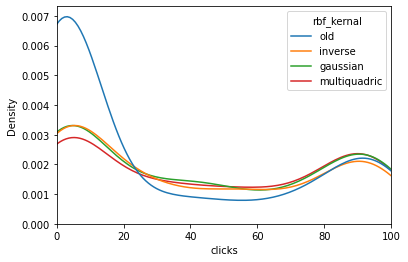

In [ ]:
res_status = generate_sample(10,10,1000)
res_status = res_status[~res_status.id.duplicated()]
res_status.reset_index(drop= True, inplace = True)
_ = res_status[res_status.status == -1]
sns.kdeplot(data = _, x = "clicks", hue = "rbf_kernal")
#plt.title("Relative Win rate increase "+ relative_win_rate(res_status))
plt.xlim(0,100)

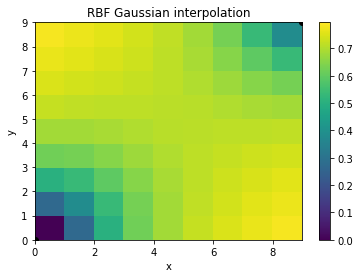

In [ ]:
idea_for_weights()

In [12]:
def CreateBoard(board):
  return copy.deepcopy(board)

In [13]:
def generate_sample(num_row, num_col, sample_size = 100, rbf_kernal = "inverse" ,epsilon = 0.03):
  num_row, num_col, threshold = (num_row,num_col,0.1)
  res_status_o = pd.DataFrame()
  res_status_n = pd.DataFrame()
  board = createBoard(num_row, num_col)
  for i in trange(sample_size):
    try:
      board = createBoard(num_row, num_col)
      board_o = CreateBoard(board)
      board_n = CreateBoard(board)
      df_o, status_o = old_solver(board_o, num_row, num_col, threshold)
      df_n, status_n = new_solver(board_n, num_row, num_col, threshold, rbf_kernal = rbf_kernal, epsilon= 0.1)
      res_status_o = pd.concat([res_status_o, pd.DataFrame(status_o)])
      res_status_n = pd.concat([res_status_n, pd.DataFrame(status_n)])
    except Exception as e:
      print(e)
  res_status = pd.concat([res_status_o, res_status_n])
  
  return res_status

In [14]:
def to_optimize(params, param_names):
  params = dict(zip(param_names, params))
  metrics = []
  def relative_win_rate(res_status, kernal):
    return (res_status[(res_status.status == 1) & (res_status.rbf_kernal == kernal) ].shape[0]/res_status[(res_status.rbf_kernal == kernal) ].shape[0]) / (res_status[(res_status.status == 1) & (res_status.rbf_kernal == "old") ].shape[0]/res_status[(res_status.rbf_kernal == "old") ].shape[0])
  for i in trange(5):
    _ = generate_sample(10, 10, 100, params["rbf_kernal"] ,params["epsilon"])
    kernal_win_rate = (_[(_.status == 1) & (_.rbf_kernal == params["rbf_kernal"]) ].shape[0]/_[(_.rbf_kernal == params["rbf_kernal"]) ].shape[0])
    old_win_rate = (_[(_.status == 1) & (_.rbf_kernal == "old") ].shape[0]/_[(_.rbf_kernal == "old") ].shape[0])
    metric = relative_win_rate(_,params["rbf_kernal"])
    metrics += [metric]
  return -1.0 * np.mean(metrics)

In [15]:
param_name = [
              'rbf_kernal',
              'epsilon'
]

param_space = [
               space.Categorical(["multiquadric", "inverse", "gaussian"], name = 'rbf_kernal'),
               space.Real(0.01,1,prior = 'uniform' ,name = 'epsilon')
]

In [16]:
optimization_function = partial(
    to_optimize,
    param_names = param_name
)

In [17]:
result = gp_minimize(
    optimization_function,
    dimensions = param_space,
    n_calls = 15,
    n_random_starts = 5,
    verbose = 10
)

Iteration No: 1 started. Evaluating function at random point.


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 177.0920
Function value obtained: -1.2700
Current minimum: -1.2700
Iteration No: 2 started. Evaluating function at random point.


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 190.3080
Function value obtained: -1.3842
Current minimum: -1.3842
Iteration No: 3 started. Evaluating function at random point.


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Cannot choose from an empty sequence


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 178.9322
Function value obtained: -1.2895
Current minimum: -1.3842
Iteration No: 4 started. Evaluating function at random point.


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 162.7028
Function value obtained: -1.4307
Current minimum: -1.4307
Iteration No: 5 started. Evaluating function at random point.


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 5 ended. Evaluation done at random point.
Time taken: 138.3454
Function value obtained: -1.3291
Current minimum: -1.4307
Iteration No: 6 started. Searching for the next optimal point.


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 6 ended. Search finished for the next optimal point.
Time taken: 141.4330
Function value obtained: -1.3575
Current minimum: -1.4307
Iteration No: 7 started. Searching for the next optimal point.


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 7 ended. Search finished for the next optimal point.
Time taken: 138.3121
Function value obtained: -1.3751
Current minimum: -1.4307
Iteration No: 8 started. Searching for the next optimal point.


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

max() arg is an empty sequence


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 8 ended. Search finished for the next optimal point.
Time taken: 139.3250
Function value obtained: -1.3193
Current minimum: -1.4307
Iteration No: 9 started. Searching for the next optimal point.


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 9 ended. Search finished for the next optimal point.
Time taken: 148.4722
Function value obtained: -1.3961
Current minimum: -1.4307
Iteration No: 10 started. Searching for the next optimal point.


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 10 ended. Search finished for the next optimal point.
Time taken: 139.7631
Function value obtained: -1.4667
Current minimum: -1.4667
Iteration No: 11 started. Searching for the next optimal point.


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Cannot choose from an empty sequence


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 139.3944
Function value obtained: -1.4473
Current minimum: -1.4667
Iteration No: 12 started. Searching for the next optimal point.


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Cannot choose from an empty sequence


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 139.1624
Function value obtained: -1.2817
Current minimum: -1.4667
Iteration No: 13 started. Searching for the next optimal point.


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 149.5303
Function value obtained: -1.3410
Current minimum: -1.4667
Iteration No: 14 started. Searching for the next optimal point.


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 143.6760
Function value obtained: -1.2897
Current minimum: -1.4667
Iteration No: 15 started. Searching for the next optimal point.


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

max() arg is an empty sequence
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 146.1099
Function value obtained: -1.5760
Current minimum: -1.5760


In [18]:
best_params = dict(zip(param_name, result.x))

In [69]:
best_params

{'rbf_kernal': 'inverse', 'epsilon': 0.6956364909708692}

In [67]:
result

          fun: -1.5759944647715547
    func_vals: array([-1.27002918, -1.38415098, -1.28952343, -1.43066559, -1.32906727,
       -1.35745508, -1.3750954 , -1.31932256, -1.39609691, -1.46673756,
       -1.44728684, -1.2816934 , -1.34100642, -1.28967444, -1.57599446])
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=823336703), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=823336703), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=823336703